In [1]:
%run ./functions_gandalf_skywalker_20210822.ipynb
%run ./engine_gandalf_skywalker_20220106.py
%run ./Genera_LIB_V5.ipynb

5.3.1


In [2]:
def carica_storico(file_name,uct_offset,type_session,resample_tf,IS,OOS,custom_session_start,custom_session_stop,noise,pct_noise):
    import os
    import talib as ta
    
    os.chdir(dir_history)
    data = load_data_intraday_fast(file_name)  
    print("Caricato storico")
    data = data.sort_index(ascending=True)
    data.index = data.index.tz_localize('Etc/Zulu')
    data.index = data.index.tz_convert(uct_offset )
    data.index = data.index.tz_localize(None)
    data = data[data!=0]
    #data = data.fillna(method="ffill")
    data = data.iloc[1:-1]
    print("Resample dei dati")
    if type_session == 1:
        dataset=resample_custom_session("5min",resample_tf ,data,custom_session_start,custom_session_stop) 
    if type_session == 0:    
        dataset=resample_standard_session("5min",resample_tf,data)
        
    if noise == 1:
        print("AGGIUNGO RUMORE")
        dataset=add_noise(dataset.open, dataset.high, dataset.low, dataset.close,dataset.volume, pct_noise)

    dataset = dataset.loc[IS:OOS]
    dataset["dayofweek"] = dataset.index.dayofweek
    dataset["day"] = dataset.index.day
    dataset["month"] = dataset.index.month
    dataset["year"] = dataset.index.year
    dataset["dayofyear"] = dataset.index.dayofyear
    dataset["week"] = dataset.index.week
    dataset["hour"] = dataset.index.hour
    dataset["minute"] = dataset.index.minute
    dataset["daily_open"] = daily_open(dataset,1)
    dataset["daily_high"] = daily_high(dataset,1)
    dataset["daily_low"] = daily_low(dataset,1)
    dataset["daily_close"] = daily_close(dataset,1)
    dataset["AVGPRICE"]=ta.AVGPRICE(dataset.open, dataset.high, dataset.low, dataset.close)
    dataset["MEDPRICE"]=ta.MEDPRICE(dataset.high, dataset.low)
    dataset["TYPPRICE"]=ta.TYPPRICE(dataset.high, dataset.low, dataset.close)
    dataset["WCLPRICE"]=ta.WCLPRICE(dataset.high, dataset.low, dataset.close)
    history=dataset.copy()
    
    print("Carico indicatori")

    
    import legitindicators

    """data_filter=dataset.iloc[:].copy()
    for e in data_filter.columns:
        data_filter[e]= legitindicators.super_smoother(data_filter[e], 10)"""
    
    #import talib as ta
    #ATR = ta.ATR(dataset.high,dataset.low,dataset.close,5)
    #ATR = ATR.fillna(0)
    #dataATR=dataset.copy()
    #for e in dataATR.columns:
        #dataATR[e]=dataATR[e]/ATR
        
    applica_indicatori=apply_indicator(dataset)
    dataset=applica_indicatori[0]
    dataset_ind = dataset.iloc[:,21:].copy()


    rules=dataset.iloc[:,21:].T.values
    rule_formulas=np.arange(len(rules))
    
    history.tail(10)
    
    history.close.plot(figsize=(20,10),title=SIMBOLO+"_"+RESAMPLE_TF)
    print("Fatto")
    return dataset , dataset_ind , history , rules, rule_formulas

In [3]:

def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower


from numba import njit
@njit
def get_final_bands_nb(close, upper, lower):
    trend = np.full(close.shape, np.nan)
    dir_ = np.full(close.shape, 1)
    long = np.full(close.shape, np.nan)
    short = np.full(close.shape, np.nan)

    for i in range(1, close.shape[0]):
        if close[i] > upper[i - 1]:
            dir_[i] = 1
        elif close[i] < lower[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lower[i] < lower[i - 1]:
                lower[i] = lower[i - 1]
            if dir_[i] < 0 and upper[i] > upper[i - 1]:
                upper[i] = upper[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lower[i]
        else:
            trend[i] = short[i] = upper[i]

    return trend, dir_, long, short


import talib
def faster_supertrend_talib(high, low, close, period=7, multiplier=3):
    avg_price = talib.MEDPRICE(high, low)
    atr = talib.ATR(high, low, close, period)
    upper, lower = get_basic_bands(avg_price, atr, multiplier)
    return get_final_bands_nb(close, upper, lower)

In [242]:
def apply_indicator(history):

    import random


    MIN_PERIOD = 5
    MAX_PERIOD = 200
    MAX_LOOKBACK = 5
    MIN_DEVIATION = 0.5
    MAX_DEVIATION = 3
    DATASET = history.iloc[:,:5]

    PRICE_LIST= ["OPEN","HIGH","LOW","CLOSE","AvgPrice","MedPrice","MedBodyPrice"]

    atr_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        atr_list.append(eval('"avg_true_range(DATAFRAME,"+str(PERIOD)+").shift("+str(SHIFT)+")"'))   
    atr_rules=[]
    for e in range(10000):
        atr_rules.append(random.choice(atr_list)+random.choice(["<",">"])+random.choice(atr_list))

    rsi_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        rsi_list.append(eval('"RSI("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+").shift("+str(SHIFT)+")"'))   
    rsi_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            rsi_rules.append(random.choice(rsi_list)+random.choice(["<",">"])+random.choice(rsi_list))
        else:
            rsi_rules.append(random.choice(rsi_list)+random.choice(["<",">"])+str(random.randrange(1 , 100, 1)))

    mfi_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        mfi_list.append(eval('"MFI(DATAFRAME,"+str(PERIOD)+").shift("+str(SHIFT)+")"')) 
    mfi_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            mfi_rules.append(random.choice(mfi_list)+random.choice(["<",">"])+random.choice(mfi_list))
        else:
            mfi_rules.append(random.choice(mfi_list)+random.choice(["<",">"])+str(random.randrange(20 , 80, 1)))   

    bb_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        DEVIATION = round(random.uniform(MIN_DEVIATION, MAX_DEVIATION),1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        UPPER_LOWER = random.randrange(0, 2, 1)
        bb_list.append(eval('"BollingerBand("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+","+str(DEVIATION)+","+str(UPPER_LOWER)+").shift("+str(SHIFT)+")"')) 
    bb_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            bb_rules.append(random.choice(bb_list)+random.choice(["<",">"])+random.choice(bb_list))
        else:
            TMP_PRICE_NAME = random.choice(PRICE_LIST)
            SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
            DATAFRAME = DATASET
            str_PRICE = TMP_PRICE_NAME+"(DATAFRAME).shift("+str(SHIFT)+")"
            bb_rules.append(random.choice(bb_list)+random.choice(["<",">"])+str_PRICE)       

    roc_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        roc_list.append(eval('"ROC("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+").shift("+str(SHIFT)+")"'))  
    roc_rules=[]
    for e in range(1000):
        if random.randrange(0, 2, 1) == 0:
            roc_rules.append(random.choice(roc_list)+random.choice(["<",">"])+random.choice(roc_list))
        else:
            roc_rules.append(random.choice(roc_list)+random.choice(["<",">"])+str(random.randrange(-10 , 10, 1)))


    mom_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        mom_list.append(eval('"Momentum("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+").shift("+str(SHIFT)+")"'))  
    mom_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            mom_rules.append(random.choice(mom_list)+random.choice(["<",">"])+random.choice(mom_list))
        else:
            mom_rules.append(random.choice(mom_list)+random.choice(["<",">"])+str(random.randrange(-10 , 10, 1))) 

    sma_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        TMP_PRICE_NAME = random.choice(PRICE_LIST)
        sma_list.append(eval('"SMA("+TMP_PRICE_NAME+"(DATAFRAME),"+str(PERIOD)+").shift("+str(SHIFT)+")"')) 
    sma_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            sma_rules.append(random.choice(sma_list)+random.choice(["<",">"])+random.choice(sma_list))
        else:
            TMP_PRICE_NAME = random.choice(PRICE_LIST)
            SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
            DATAFRAME = DATASET
            str_PRICE = TMP_PRICE_NAME+"(DATAFRAME).shift("+str(SHIFT)+")"
            sma_rules.append(random.choice(sma_list)+random.choice(["<",">"])+str_PRICE)     

    adx_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        adx_list.append(eval('"adx(DATAFRAME,"+str(PERIOD)+").shift("+str(SHIFT)+")"')) 
    adx_rules=[]
    for e in range(10000):
        adx_rules.append(random.choice(adx_list)+random.choice(["<",">"])+random.choice(adx_list))

    trix_list=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        PERIOD = random.randrange(MIN_PERIOD , MAX_PERIOD, 1)
        trix_list.append(eval('"trix(DATAFRAME,"+str(PERIOD)+").shift("+str(SHIFT)+")"'))   
    trix_rules=[]
    for e in range(10000):
        if random.randrange(0, 2, 1) == 0:
            trix_rules.append(random.choice(trix_list)+random.choice(["<",">"])+random.choice(trix_list))
        else:
            TMP_PRICE_NAME = random.choice(PRICE_LIST)
            SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
            DATAFRAME = DATASET
            str_PRICE = TMP_PRICE_NAME+"(DATAFRAME).shift("+str(SHIFT)+")"
            trix_rules.append(random.choice(trix_list)+random.choice(["<",">"])+str_PRICE)     
            
    range_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET 
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = randrange_float(0.25, 5, 0.25)
        range_rules.append(eval('"Range(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Range(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
            

    lista_rules=[]
    lista_indicatori=[atr_rules,rsi_rules,mfi_rules,bb_rules,roc_rules,mom_rules,sma_rules,adx_rules,trix_rules,range_rules]
    for e in lista_indicatori:
        x=random.choices(e,k=100)
        lista_rules=lista_rules+x
    
    for e in tqdm(lista_rules):
        tmp_check=eval(e)
        history[e]=tmp_check
        
    return history , history.columns.to_list()


In [11]:
def apply_indicator(history):

    import random


    MIN_PERIOD = 5
    MAX_PERIOD = 200
    MAX_LOOKBACK = 5
    MIN_DEVIATION = 0.5
    MAX_DEVIATION = 3
    DATASET = history.iloc[:,:5]

    PRICE_LIST= ["OPEN","HIGH","LOW","CLOSE","AvgPrice","MedPrice","MedBodyPrice"]
    
    range_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        range_rules.append(eval('"Range(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Range(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
            

    body_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        body_rules.append(eval('"Body(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Body(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
        
    body_range_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        SHIFT1 = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        body_range_rules.append(eval('"Range(DATAFRAME).shift("+str(SHIFT)+")"+random.choice(["<",">"])+"(Body(DATAFRAME).shift("+str(SHIFT1)+")*"+str(MOLTI)+")"'))
        
    High_Close_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        High_Close_rules.append(eval('"High_Close(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(High_Close(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
    
    
    High_Open_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        High_Open_rules.append(eval('"High_Open(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(High_Open(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
        
    Low_Close_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        Low_Close_rules.append(eval('"Low_Close(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Low_Close(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
    
    Low_Open_rules=[]
    for e in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(1 , MAX_LOOKBACK, 1)
        MOLTI = round(random.uniform(0.25, 5), 1)
        Low_Open_rules.append(eval('"Low_Open(DATAFRAME).shift(1)"+random.choice(["<",">"])+"(Low_Open(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))
            
    lista_rules=[]
    lista_indicatori=[range_rules,body_rules,body_range_rules,High_Close_rules, High_Open_rules,Low_Close_rules,Low_Open_rules]
    for e in lista_indicatori:
        x=random.choices(e,k=1000)
        lista_rules=lista_rules+x
    
    for e in tqdm(lista_rules):
        tmp_check=eval(e)
        history[e]=tmp_check
        
    return history , history.columns.to_list()

In [4]:
def randrange_float(start, stop, step):
    return random.randint(0, int((stop - start) / step)) * step + start

def apply_indicator(history):

    import random


    MAX_LOOKBACK = 5
    DATASET = history.iloc[:,:5]

    log_price=["OpenToLowLog",
    "OpenToAvgPriceLog",
    "OpenToMedPriceLog",
    "OpenToOpenLog",
    "OpenToMedBodyPriceLog",
    "CloseToMedPriceLog",
    "CloseToCloseLog",
    "CloseToLowLog",
    "CloseToAvgPriceLog",
    "CloseToMedBodyPriceLog",
    "HighToCloseLog",
    "HighToOpenLog",
    "HighToMedBodyPriceLog",
    "HighToMedPriceLog",
    "HighToAvgPriceLog",
    "HighToHighLog",
    "LowToLowLog",
    "AvgPriceToMedPriceLog",
    "AvgPriceToLowLog",
    "AvgPriceToAvgPriceLog",
    "AvgPriceToMedBodyPriceLog",
    "MedPriceToLowLog",
    "MedBodyPriceToLowLog",
    "MedPriceToMedBodyPriceLog",
    "MedPriceToMedPriceLog",
    "MedBodyPriceToMedBodyPriceLog",
    "RangeLog",
    "BodyLog",
    "BodyToRangeLog"]

    lista_rules=[]


    for e0 in range(10000):
        DATAFRAME = DATASET
        SHIFT = random.randrange(2 , MAX_LOOKBACK, 1)
        log_name=random.choices(log_price)[0]
        MOLTI=randrange_float(0.5 ,5 ,0.5)
        lista_rules.append(eval('"'+log_name+'(DATAFRAME).shift(1)"+random.choice(["<",">"])+"('+log_name+'(DATAFRAME).shift("+str(SHIFT)+")*"+str(MOLTI)+")"'))

    for e in tqdm(lista_rules):
        tmp_check=eval(e)
        history[e]=tmp_check
    
    return history , history.columns.to_list()

def eval_pattern(ptn):
    for e in ptn:
        exec(e,dataset)

####################### pattern

def apply_indicator(dataset):

    dataset=dataset.copy()
    
    ptn=pattern_translator()

    for e in tqdm(range(1,len(ptn))):
        for r in ptn["p"+str(e)]:
            exec(r)
        
    return dataset , dataset.columns

In [5]:
dir_home=(r"C:\Users\Drako\Genetico_V3")
dir_history=(r"C:\Users\Drako\TS_API")

In [6]:
def info_simboli():
    import os
    import numpy as np
    import pandas as pd

    valori=pd.read_csv("Markets_Specifications_Live.csv",sep=",",encoding='cp1252')
    valori.reset_index(inplace=True)
    valori.Exchange_Time=np.where(valori.Exchange_Time==-6,"CST6CDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="-5","EST5EDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="1","CET",valori.Exchange_Time)
    valori["Simbolo"]=valori.Physical
    print("Calcolo Min Avg Trade per mercato...")
    ls_lp , ls_std = last_price_std(valori)
    valori["Last_Price"] = ls_lp
    valori["Standard_Deviation"] = ls_std 
    valori["Min_Avg_Trade"] = (valori.BigPointValue*valori.Last_Price)
    valori["Min_Avg_Trade"] = (valori["Min_Avg_Trade"]*0.0006).round()  ##### delta x modificare min avg trade
    valori=valori[(valori.Physical!="KC")&(valori.Physical!="TY")]
    return valori


os.chdir(dir_home)
valori=info_simboli()

valori

Calcolo Min Avg Trade per mercato...


  0%|          | 0/27 [00:00<?, ?it/s]

,index,SecurityName,Exchange Code,Physical,Underlying Future,MarketTypeName,Exchange,BigPointValue,Unit,Margins,...,Custom Close,Tick,Cost,AMP_simb,Exchange_Time,TT_Code,Simbolo,Last_Price,Standard_Deviation,Min_Avg_Trade
0,0,Australian Dollar,6A,AD,Australian Dollar,Currencies,CME,100000,0.00,2000,...,1400,0.000100,25,DA6,CST6CDT,6A,AD,0.67405,0.089246,40.0
1,1,British Pound,6B,BP,British Pound,Currencies,CME,62500,0.00,2500,...,1400,0.000100,25,BP6,CST6CDT,6B,BP,1.19130,0.158153,45.0
2,2,Crude Oil,CL,CL,Crude Oil,Energies,CME,1000,0.10,6000,...,1430,0.010000,50,CLE,EST5EDT,CL,CL,102.83000,29.720852,62.0
3,3,Euro FX,6E,EC,Euro FX,Currencies,CME,125000,0.00,3000,...,1400,0.000100,25,EU6,CST6CDT,6E,EC,1.00940,0.125934,76.0
4,4,E-mini S&P 500,ES,ES,E-mini S&P 500,Stock Indices,CME,50,0.10,12000,...,1515,0.250000,25,EP,CST6CDT,ES,ES,3858.00000,944.833453,116.0
5,5,DAX Futures,FDAX,FDAX,DAX Futures,Stock Indices,EUREX,25,0.20,30000,...,2200,0.500000,50,FDX,CET,FDAX,FDAX,12824.00000,2503.541585,192.0
6,6,EURO STOXX 50 Index,FESX,FESX,EURO STOXX 50 Index,Stock Indices,EUREX,5,0.00,3000,...,2200,0.500000,20,DSX,CET,FESX,FESX,3460.00000,795.870558,10.0
7,7,Euro Bund,FGBL,FGBL,Euro Bund,Fixed Income,EUREX,1000,0.00,2400,...,2200,0.010000,20,DB,CET,FGBL,FGBL,151.27000,21.008999,91.0
8,8,Gold,GC,GC,Gold,Metals,CME,100,0.10,8500,...,1500,0.100000,60,GCE,EST5EDT,GC,GC,1731.90000,210.684785,104.0
9,9,Copper,HG,HG,Copper,Metals,CME,25000,0.00,7500,...,1500,0.050000,60,CPE,EST5EDT,HG,HG,3.42500,0.616178,51.0


# Carico Dati e Indicatori STANDARD

Caricato storico
Resample dei dati
Carico indicatori


  0%|          | 0/10000 [00:00<?, ?it/s]

Fatto


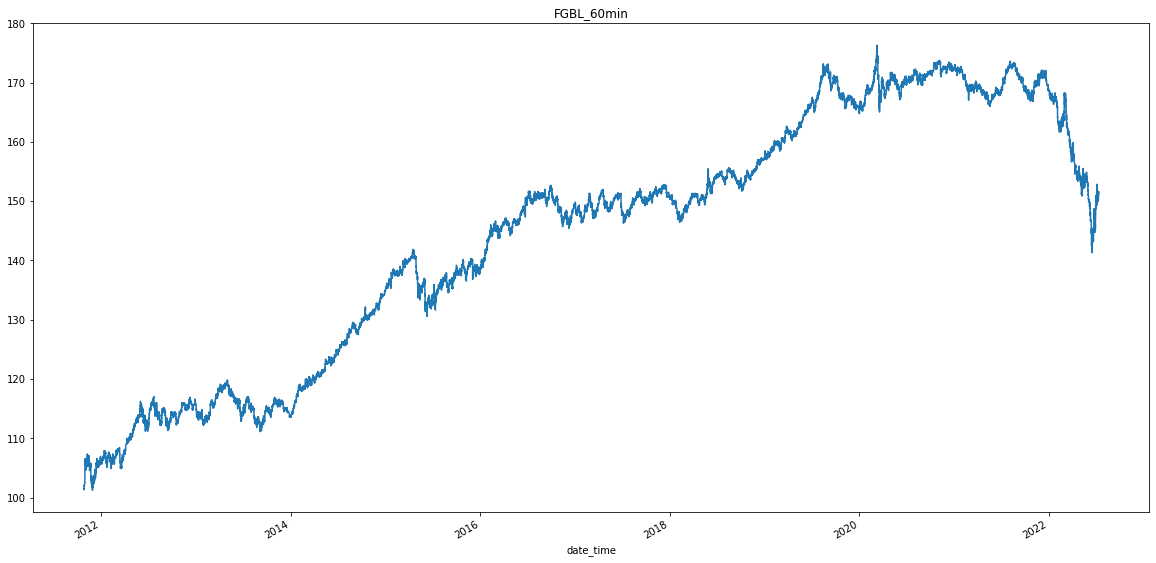

In [7]:

SIMBOLO = "FGBL"

TYPE_SESSION = 1    
RESAMPLE_TF = "60min"  ### RESAMPLE POSSIBILI "5min","15min","30min","60min","120min","240min","480min","1380min","1440min"]
START_DATE = "2010-01-01"
END_DATE = "2023-01-01"


dataset , dataset_ind , history , rules, rule_formulas , bigpointvalue , tick , utc_offset , custom_session_start ,\
custom_session_stop , costi = environment(SIMBOLO,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE)

In [8]:
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

for k in range(1,25):

    EXIT = k
    DIREZIONE = "long"
    tg=target(DIREZIONE,EXIT,history)
    tg=pd.Series(index=history.index,data=tg)
    tg=tg.fillna(0)
    Y=tg
    Y=np.where(Y<-1000,-1,Y)
    Y=np.where(Y>1000,1,Y)
    Y=np.where((Y!=1)&(Y!=-1),0,Y)
    Xx=rules.T

    # Feature Selection with Univariate Statistical Tests

    # load data

    test = SelectKBest(score_func=f_classif, k=4)
    fit = test.fit(Xx, Y)
    # summarize scores
    set_printoptions(precision=3)
    #print(fit.scores_)
    fi=pd.Series(fit.scores_)
    fi=fi.sort_values(ascending=False)
    print("")
    print("USCITA A:",k,"BARRE")
    
    display(fi.head())


USCITA A: 1 BARRE


11      9.424074
941     9.381063
1285    9.360778
1533    9.338509
295     9.329213
dtype: float32


USCITA A: 2 BARRE


1191    7.682009
598     7.673856
1599    6.681769
855     5.692310
1558    5.566666
dtype: float32


USCITA A: 3 BARRE


1599    6.858026
1558    6.255307
1191    6.200688
598     6.188108
1660    5.972531
dtype: float32


USCITA A: 4 BARRE


436    9.854400
18     9.838739
935    9.730186
392    9.691520
700    9.583114
dtype: float32


USCITA A: 5 BARRE


1378    7.740407
1507    7.710114
436     7.677372
18      7.651470
935     7.554208
dtype: float32


USCITA A: 6 BARRE


1672    11.864443
986     11.856708
876      9.639563
425      9.557293
1507     7.403406
dtype: float32


USCITA A: 7 BARRE


700     6.467746
597     6.390500
1259    6.384459
436     6.338827
1226    6.333160
dtype: float32


USCITA A: 8 BARRE


143     7.325361
1432    7.321435
1152    7.313600
492     7.304576
1025    7.286911
dtype: float32


USCITA A: 9 BARRE


720     10.063255
423      8.601977
298      8.555296
1191     8.513927
598      8.472543
dtype: float32


USCITA A: 10 BARRE


1191    10.416888
423     10.388265
598     10.373561
298     10.346918
1668    10.128922
dtype: float32


USCITA A: 11 BARRE


639     13.977914
640     13.627489
731     12.916888
598     12.888199
1668    12.585264
dtype: float32


USCITA A: 12 BARRE


639    9.067737
524    8.253756
640    8.039492
457    7.783280
298    7.686753
dtype: float32


USCITA A: 13 BARRE


1558    7.980882
1288    7.918557
1036    7.891126
347     7.891126
1660    7.853642
dtype: float32


USCITA A: 14 BARRE


524     8.392580
457     8.017469
1168    7.870292
672     7.417812
499     7.367683
dtype: float32


USCITA A: 15 BARRE


1730    8.360815
653     8.195467
720     8.179557
252     7.346166
44      7.293570
dtype: float32


USCITA A: 16 BARRE


1558    9.002178
317     8.903909
1660    8.668124
46      8.326788
1730    8.288789
dtype: float32


USCITA A: 17 BARRE


524     8.354974
457     8.169429
1168    7.334055
1622    7.160358
720     6.903703
dtype: float32


USCITA A: 18 BARRE


1361    13.913500
1506    13.703173
1257    13.650324
822     11.706709
305     11.672445
dtype: float32


USCITA A: 19 BARRE


1361    12.753261
1506    12.750922
305     12.670758
1257    12.496016
1236    12.059602
dtype: float32


USCITA A: 20 BARRE


1361    15.460706
1672    15.365772
1506    15.226972
1257    15.189624
986     13.060071
dtype: float32


USCITA A: 21 BARRE


1361    11.979847
1506    11.798768
1257    11.726553
1672    10.951266
1223     9.874306
dtype: float32


USCITA A: 22 BARRE


1361    11.593163
1506    11.227522
1257    11.149498
1672    10.494711
1223     9.428752
dtype: float32


USCITA A: 23 BARRE


1361    10.626524
1506    10.465913
1257    10.380146
1223     8.831487
1672     8.820861
dtype: float32


USCITA A: 24 BARRE


720     6.171844
44      5.711464
179     5.590782
93      5.486611
1672    5.474051
dtype: float32

In [9]:
EXIT = 20
DIREZIONE = "long"
tg=target(DIREZIONE,EXIT,history)
tg=pd.Series(index=history.index,data=tg)
tg=tg.fillna(0)
Y=tg
Y=np.where(Y<-1000,-1,Y)
Y=np.where(Y>1000,1,Y)
Y=np.where((Y!=1)&(Y!=-1),0,Y)
Xx=rules.T

# Feature Selection with Univariate Statistical Tests

# load data

test = SelectKBest(score_func=f_classif, k=4)
fit = test.fit(Xx, Y)
# summarize scores
set_printoptions(precision=3)
#print(fit.scores_)
fi=pd.Series(fit.scores_)
fi=fi.sort_values(ascending=False)
print("USCITA A:",EXIT,"BARRE")
print("")
display(fi.head())

ok=fi[:300].index
X2=[]

for e in ok:
    X2.append(rules[e])

USCITA A: 20 BARRE



1361    15.460706
1672    15.365772
1506    15.226972
1257    15.189624
986     13.060071
dtype: float32

<AxesSubplot:>

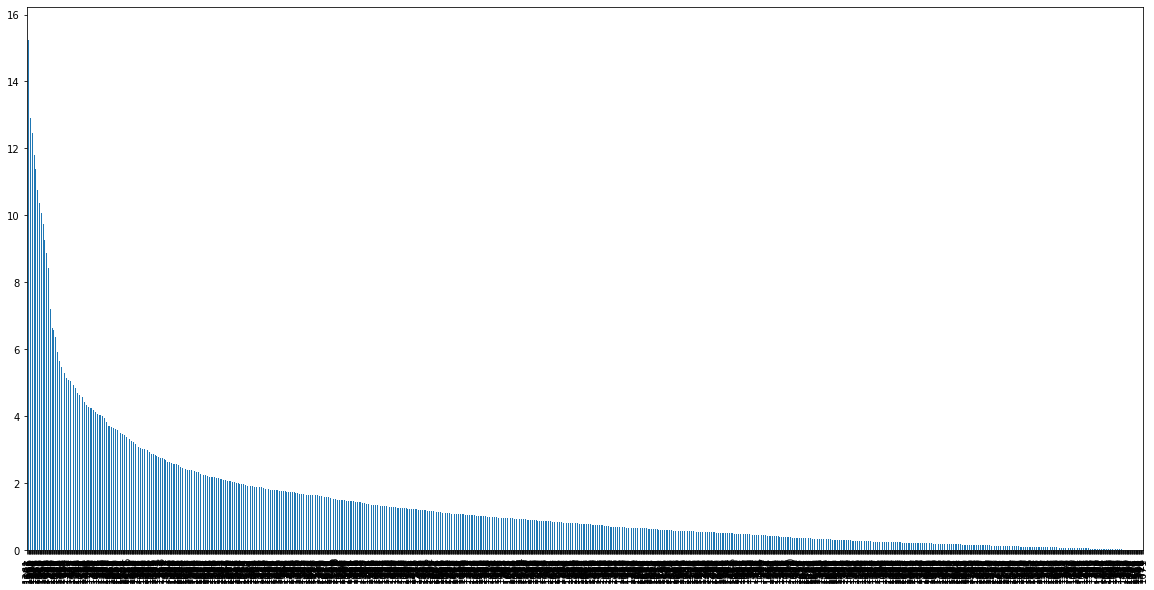

In [10]:
#fi=pd.Series(model.feature_importances_)
fi=pd.Series(fit.scores_)
fi=fi.sort_values(ascending=False)
fi.plot.bar(figsize=(20,10))

In [11]:
from numba import jit
@jit(nopython=True)
def strategy(tmp,exit,target_monetario,costi):
    for el in range(len(tmp)):
        if tmp[el] == 1:
            tmp[el+1:el+exit+1]=0
    d=tmp*target_monetario
    d[d != 0 ]=d[d != 0 ]-costi
    return d

def stampa(lista,title):
    serie=pd.Series(lista)
    serie=serie[serie!=0].dropna()
    serie.cumsum().plot(figsize=(10,10),title=title)
    #for e in idx:
        #plt.axvline(x=e,color="g",alpha=1)
    plt.show()

In [12]:
#%%time

Barre_min = 19
Barre_max = 23
N_STRATEGY = 10
EXIT = random.randrange(Barre_min, Barre_max)
DIREZIONE = "long"
n_split = random.randrange(100, 200)
avg_trade_train_min = 150+costi
avg_trade_test_min = 150+costi
n_op_train_min = 150
n_op_test_min = 150
OOS=2000
TIME_FRAME=RESAMPLE_TF
tg=target(DIREZIONE,EXIT,history)
y=tg.T
X=X2
DATAFRAME=history

long_strategy=[]
short_strategy=[]
check_OOS_L=[]
check_OOS_S=[]
cnt_total=0

print("PARAMETRI:")
print("avg_trade_train_min:",avg_trade_train_min)
print("avg_trade_test_min:",avg_trade_test_min)
print("n_op_train_min:",n_op_train_min)
print("n_op_test_min:",n_op_test_min)


while True:
    random.seed(a=None, version=2)


    X_dim = range(len(X))

    cnt=0
    while True:
        cnt_total=cnt_total+1
        cnt = cnt+1
        s=random.sample(X_dim, 5)
        c=X[s[0]]&X[s[1]]&X[s[2]]&X[s[3]]&~X[s[4]]
        m=strategy(c,EXIT,y,0)
        m_r=m*(-1)
       
        

        if len(m[m!=0])>=n_op_train_min+n_op_train_min:
            m_split = np.array_split(m[:-OOS] ,n_split)
            train = np.concatenate(m_split[0::2])
            test = np.concatenate(m_split[1::2])
            train=train[train!=0]
            test=test[test!=0]
            avg_train=np.sum(train)/len(train)
            avg_test=np.sum(test)/len(test)
            
            if (avg_train > avg_trade_train_min)&(len(train)>n_op_train_min)&(avg_test>avg_trade_test_min)&(len(test)>n_op_test_min)&(skew(m[:-OOS])>7)&(len(long_strategy)<N_STRATEGY):
                long_strategy.append(m)
                print("Strategia Long N°:",cnt,"generate Uscita:",EXIT,"Split:",n_split)
                check_OOS_L.append(np.sum(m[-OOS:]))
                #EXIT = random.randrange(4, 20) 
                #n_split = random.randrange(50, 150) 
                #tg=target(DIREZIONE,EXIT,history)
                #y=tg.T
                break

            avg_train_r=avg_train*(-1)
            avg_test_r=avg_test*(-1)       
            if (avg_train_r > avg_trade_train_min)&(len(train)>n_op_train_min)&(avg_test_r>avg_trade_test_min)&(len(test)>n_op_test_min)&(skew(m_r[:-OOS])>7)&(len(short_strategy)<N_STRATEGY):
                m=m_r 
                check_OOS_S.append(np.sum(m[-OOS:]))
                short_strategy.append(m)
                print("Strategia Short N°:",cnt,"generate Uscita:",EXIT,"Split:",n_split)
                #EXIT = random.randrange(4, 20) 
                #n_split = random.randrange(50, 150) 
                #tg=target(DIREZIONE,EXIT,history)
                #y=tg.T
                break   


        if cnt == 20000:
            
            print("RANDOMIZZO EXIT - SLIP")
            EXIT = random.randrange(Barre_min, Barre_max)
            n_split = random.randrange(100, 200) 
            tg=target(DIREZIONE,EXIT,history)
            y=tg.T
            
            avg_trade_train_min = avg_trade_train_min-10
            avg_trade_test_min = avg_trade_test_min-10
            n_op_train_min = n_op_train_min-10
            n_op_test_min = n_op_test_min-10
            print("NESSUN RISULTATO - UPGRADE PARAMETRI")
            print("avg_trade_train_min:",avg_trade_train_min)
            print("avg_trade_test_min:",avg_trade_test_min)
            print("n_op_train_min:",n_op_train_min)
            print("n_op_test_min:",n_op_test_min)
            break
            
    if (len(long_strategy)>=N_STRATEGY) & (len(short_strategy)>=N_STRATEGY):
        print("")
        print("############# Fatto ############# GENERATE:",cnt_total,"STRATEGIE")
        break
        
ln=pd.DataFrame(long_strategy).T
ln.index=history.index
ln.columns = ["long_%d" % i for i,_ in enumerate(ln.columns)]
ls=pd.DataFrame(short_strategy).T
ls.index=history.index
ls.columns = ["short_%d" % i for i,_ in enumerate(ls.columns)]

PARAMETRI:
avg_trade_train_min: 170
avg_trade_test_min: 170
n_op_train_min: 150
n_op_test_min: 150
RANDOMIZZO EXIT - SLIP
NESSUN RISULTATO - UPGRADE PARAMETRI
avg_trade_train_min: 160
avg_trade_test_min: 160
n_op_train_min: 140
n_op_test_min: 140
RANDOMIZZO EXIT - SLIP
NESSUN RISULTATO - UPGRADE PARAMETRI
avg_trade_train_min: 150
avg_trade_test_min: 150
n_op_train_min: 130
n_op_test_min: 130
RANDOMIZZO EXIT - SLIP
NESSUN RISULTATO - UPGRADE PARAMETRI
avg_trade_train_min: 140
avg_trade_test_min: 140
n_op_train_min: 120
n_op_test_min: 120
RANDOMIZZO EXIT - SLIP
NESSUN RISULTATO - UPGRADE PARAMETRI
avg_trade_train_min: 130
avg_trade_test_min: 130
n_op_train_min: 110
n_op_test_min: 110
RANDOMIZZO EXIT - SLIP
NESSUN RISULTATO - UPGRADE PARAMETRI
avg_trade_train_min: 120
avg_trade_test_min: 120
n_op_train_min: 100
n_op_test_min: 100
RANDOMIZZO EXIT - SLIP
NESSUN RISULTATO - UPGRADE PARAMETRI
avg_trade_train_min: 110
avg_trade_test_min: 110
n_op_train_min: 90
n_op_test_min: 90
Strategia Long 

In [13]:
ckL=pd.Series(check_OOS_L)
ckS=pd.Series(check_OOS_S)

In [14]:
from scipy.stats import wilcoxon
res_L = wilcoxon(ckL)
res_S = wilcoxon(ckS)
res_L , res_S

(WilcoxonResult(statistic=4.0, pvalue=0.013671875),
 WilcoxonResult(statistic=6.0, pvalue=0.02734375))

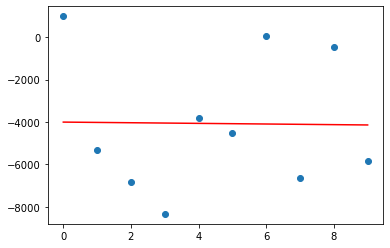

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
X = ckL.index.values.reshape(-1, 1)  # iloc[:, 1] is the column of X
Y = ckL.values.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

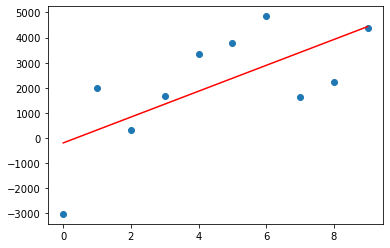

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
X = ckS.index.values.reshape(-1, 1)  # iloc[:, 1] is the column of X
Y = ckS.values.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [26]:
####################  CORRELAZIONE LONG 

tmp=ln.corr()
tmp_s=tmp.sum()
tmp_min=tmp_s.idxmin()
srt=tmp[tmp_min].sort_values()
ok=srt.iloc[:4].index.to_list()
ok.extend([tmp_min])
ln=ln[ok]
ln.tail()

,long_0,long_2,long_5,long_9,long_4
date_time,,,,,
2022-07-11 18:00:00,0.0,0.0,0.0,0.0,0.0
2022-07-11 19:00:00,0.0,0.0,0.0,0.0,0.0
2022-07-11 20:00:00,0.0,0.0,0.0,0.0,0.0
2022-07-11 21:00:00,0.0,0.0,0.0,0.0,0.0
2022-07-11 22:00:00,0.0,0.0,0.0,0.0,0.0


In [27]:
####################  CORRELAZIONE SHORT

tmp=ls.corr()
tmp_s=tmp.sum()
tmp_min=tmp_s.idxmin()
srt=tmp[tmp_min].sort_values()
ok=srt.iloc[:4].index.to_list()
ok.extend([tmp_min])
ls=ls[ok]
ls.tail()

,short_3,short_6,short_7,short_4,short_1
date_time,,,,,
2022-07-11 18:00:00,-0.0,-0.0,-0.0,-0.0,-0.0
2022-07-11 19:00:00,-0.0,-0.0,-0.0,-0.0,-0.0
2022-07-11 20:00:00,-0.0,-0.0,-0.0,-0.0,-0.0
2022-07-11 21:00:00,-0.0,-0.0,-0.0,-0.0,-0.0
2022-07-11 22:00:00,-0.0,-0.0,-0.0,-0.0,-0.0


49.29358222047075 12.052815665107207


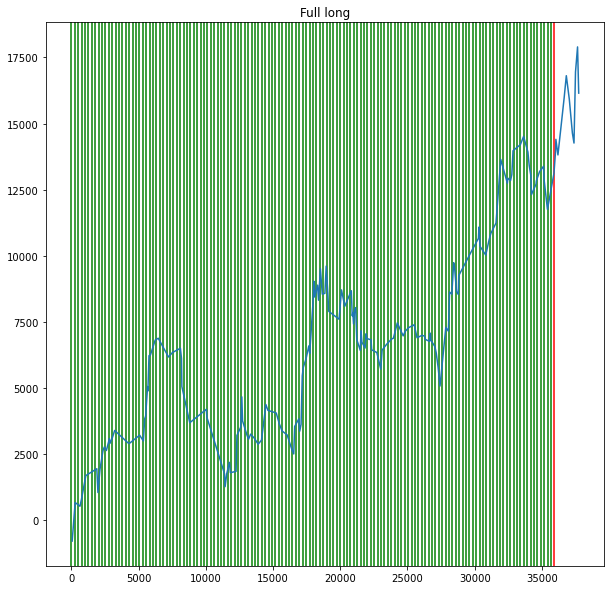

In [19]:
print(m.std(),skew(m))

for e in range(0,len(y)-OOS,len(m_split[0])):
    plt.axvline(x=e,color="g",alpha=1)
plt.axvline(x=len(y)-OOS,color="r",alpha=1)
stampa(m,"Full "+DIREZIONE)

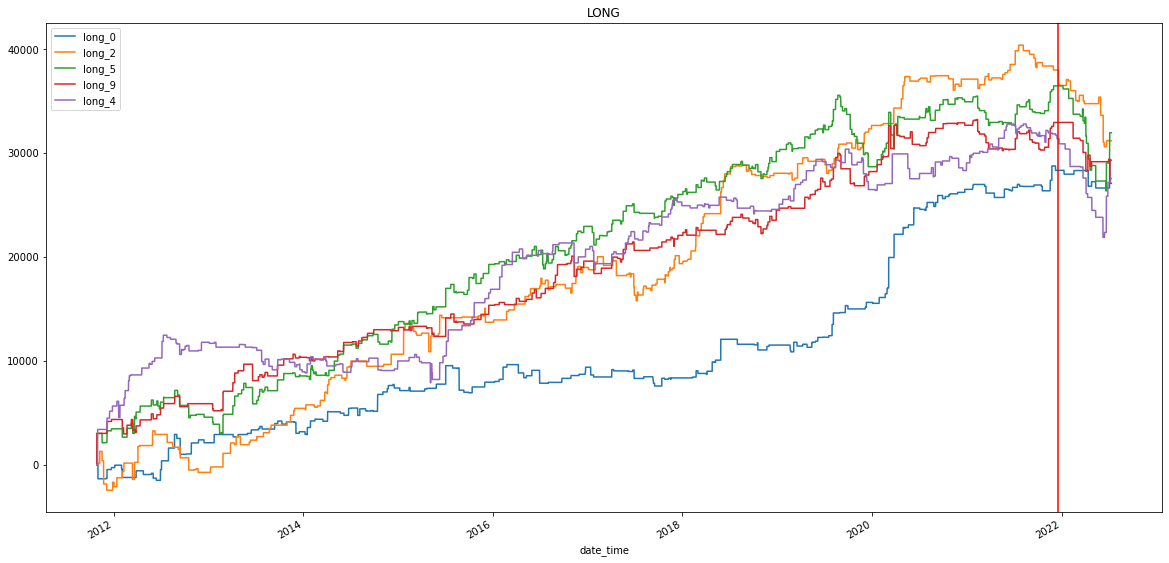

In [28]:
ln.cumsum().plot(figsize=(20,10),title="LONG")
plt.axvline(x=ln.iloc[len(y)-OOS].name,color="r",alpha=1)
#plt.axvline(x=ln.iloc[len(y)-4000].name,color="r",alpha=1)

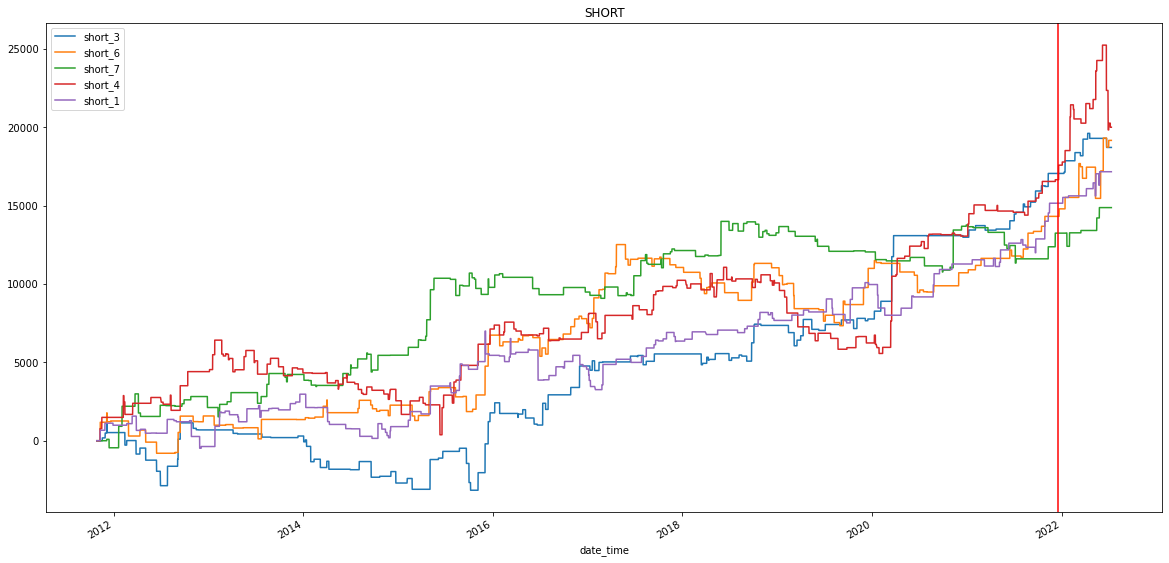

In [29]:
ls.cumsum().plot(figsize=(20,10),title="SHORT")
plt.axvline(x=ls.iloc[len(y)-OOS].name,color="r",alpha=1)
#plt.axvline(x=ln.iloc[len(y)-4000].name,color="r",alpha=1)

In [25]:
newdf = pd.concat([ln,ls],axis=1).fillna(0)
w=newdf.iloc[:-1].std()
w=w.to_frame()#.round()
w.columns=(["STD"])
w["weigh"]=w.STD.max()
w["app"]=(w.weigh/w.STD).round(2)
w

,STD,weigh,app
long_0,46.957074,63.675662,1.36
long_1,55.799882,63.675662,1.14
long_2,55.621041,63.675662,1.14
long_3,49.333725,63.675662,1.29
long_4,59.398757,63.675662,1.07
long_5,63.675662,63.675662,1.00
long_6,47.899201,63.675662,1.33
long_7,52.115990,63.675662,1.22
long_8,62.746909,63.675662,1.01
long_9,54.363837,63.675662,1.17


In [33]:
ptf=pd.concat([ln,ls*(2)],axis=1)

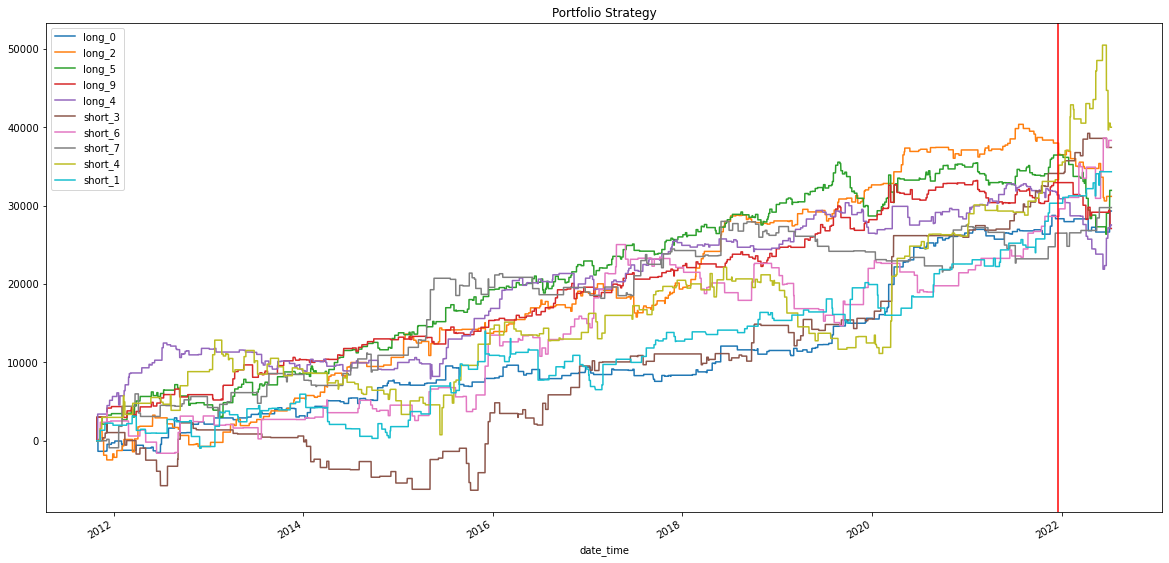

In [34]:
ptf.cumsum().plot(figsize=(20,10),title="Portfolio Strategy")
plt.axvline(x=ln.iloc[len(y)-OOS].name,color="r",alpha=1)
#plt.axvline(x=ln.iloc[len(y)-4000].name,color="r",alpha=1)

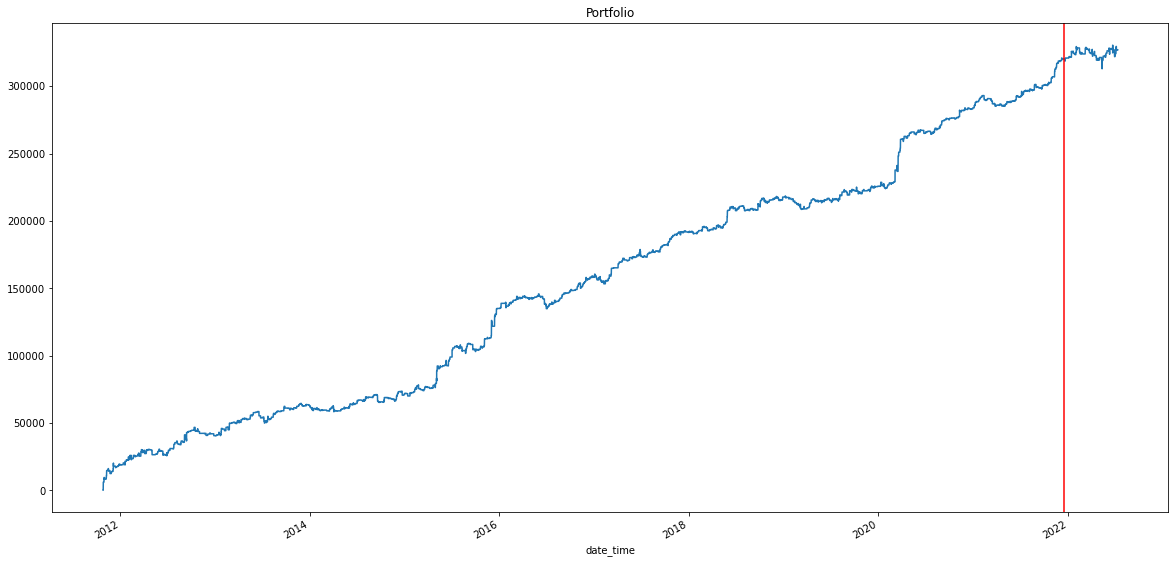

In [35]:
ptf.sum(axis=1).cumsum().plot(figsize=(20,10),title="Portfolio")
plt.axvline(x=ln.iloc[len(y)-OOS].name,color="r",alpha=1)

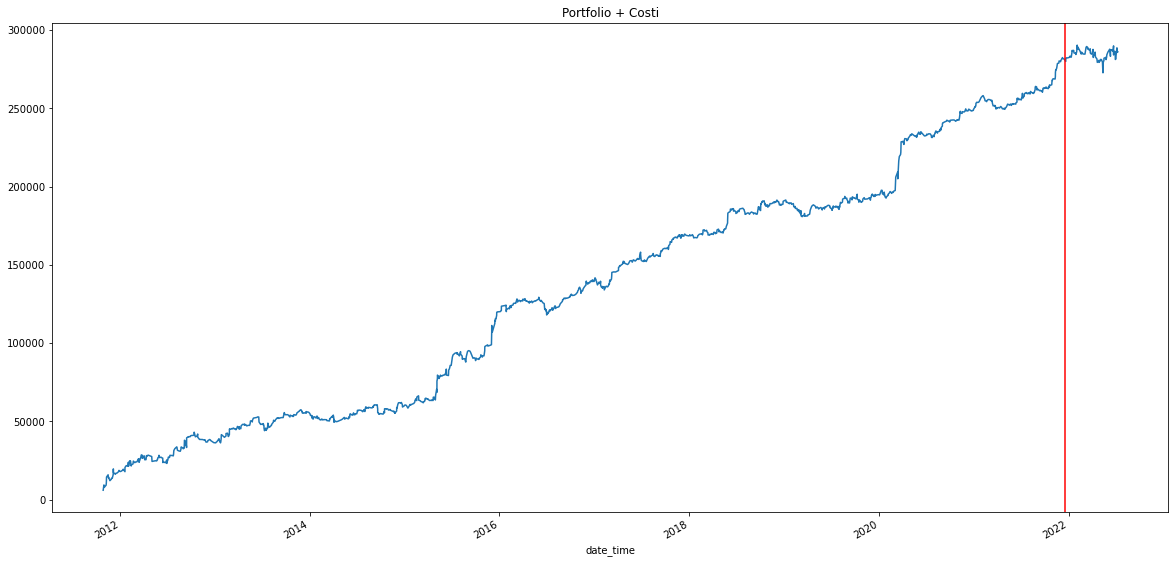

In [51]:
ptf[ptf!=0]=ptf[ptf!=0]-costi

ptf.sum(axis=1).cumsum().plot(figsize=(20,10),title="Portfolio + Costi")
plt.axvline(x=ln.iloc[len(y)-OOS].name,color="r",alpha=1)

In [36]:
ptf=ptf.loc[~(ptf==0).all(axis=1)]

ptf.corr()

,long_0,long_2,long_5,long_9,long_4,short_3,short_6,short_7,short_4,short_1
long_0,1.000000,-0.005739,0.287461,0.243886,-0.004743,-0.006736,-0.004537,-0.014172,-0.003991,-0.004714
long_2,-0.005739,1.000000,0.054981,-0.004575,-0.004257,-0.069323,-0.116671,-0.003702,-0.004014,-0.018102
long_5,0.287461,0.054981,1.000000,0.691664,-0.003808,-0.102365,-0.073926,-0.003312,-0.003205,-0.013141
long_9,0.243886,-0.004575,0.691664,1.000000,-0.003781,-0.003884,-0.003617,-0.003288,-0.003182,-0.003758
long_4,-0.004743,-0.004257,-0.003808,-0.003781,1.000000,-0.021478,-0.052754,-0.017070,-0.002961,-0.003497
short_3,-0.006736,-0.069323,-0.102365,-0.003884,-0.021478,1.000000,0.329269,-0.003143,0.124671,-0.003593
short_6,-0.004537,-0.116671,-0.073926,-0.003617,-0.052754,0.329269,1.000000,-0.002926,0.010125,-0.003345
short_7,-0.014172,-0.003702,-0.003312,-0.003288,-0.017070,-0.003143,-0.002926,1.000000,-0.002574,-0.003041
short_4,-0.003991,-0.004014,-0.003205,-0.003182,-0.002961,0.124671,0.010125,-0.002574,1.000000,-0.002943
short_1,-0.004714,-0.018102,-0.013141,-0.003758,-0.003497,-0.003593,-0.003345,-0.003041,-0.002943,1.000000


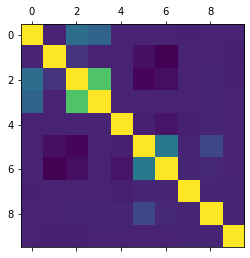

In [37]:
plt.matshow(ptf.corr())
plt.show()

In [38]:
for e in ptf.columns:
    x=ptf[e]
    x=x[x!=0]
    k=performance_report_gen(x)
    k["nome"]=e
    k["pnl_OOS"]=x.loc[ln.iloc[len(y)-OOS].name:].sum()
    display(k)

,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,29320.0,-4380.0,194,151.13,2.05,59.28,0.23,146.173536,0.738816,1.41,long_0,980.0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,31190.0,-4990.0,249,125.26,1.64,63.05,0.48,173.4946,-0.408214,0.96,long_2,-6810.0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,31960.0,-5200.0,332,96.27,1.48,59.64,0.35,198.198885,0.465787,1.0,long_5,-4510.0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,27090.0,-5340.0,239,113.35,1.61,63.18,0.48,169.194822,0.003134,0.94,long_9,-5860.0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,27550.0,-5330.0,263,104.75,1.53,54.37,0.25,184.907123,0.668015,1.28,long_4,-3820.0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,37440.0,-6860.0,131,285.8,1.8,58.02,0.2,245.652368,0.774324,1.3,short_3,3320.0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,38340.0,-8300.0,147,260.82,1.67,55.78,0.22,269.575746,0.436435,1.32,short_6,9700.0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,29760.0,-7060.0,139,214.1,1.63,51.8,0.19,231.966933,0.811965,1.52,short_7,3260.0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,40020.0,-11480.0,190,210.63,1.49,54.74,0.15,319.510085,-0.06522,1.23,short_4,6700.0


,Profit,MaxDD,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,nome,pnl_OOS
0,34340.0,-7740.0,160,214.63,1.67,55.0,0.27,233.428526,0.111865,1.36,short_1,4020.0
